# Introduction

The aim of this notebook is to predict the winner of a battle opposing two pokemons. File *battles.csv* gives two pokemons and which one wins this battle. File *pokemon.csv* gives features for each pokemon: name, type 1, type 2, HP, attack, defense, special attack, special defense, speed, generation and legendary.

We suppose that from a given pair of pokemon, the winner will be always the same, i.e. the battle outcomes are deterministic.

Part **Imports** just import the necessary libraries and classes.

Part **Data import, cleaning and transformation** imports the data, clean it (look for anomalies and aberrant data) and apply minor tranformations (turn categorical to numeric, merge...). The data is already quite clean and complete, so only few lines are removed.

Part **First analyses and visualisations** has a quick look at the train data coverage and at the correlations between features. The battle data seems to offer enough information on all pokemons. The legendary feature and numeric features (HP, attack, defense, special attack, special defense, speed) are correlated to each over. Thus pokemons are not balanced, i.e. there are strong and weak pokemons. Moreover, a further study might need a PCA.

Part **Relative features** transforms all features to "relative feature", i.e. for each battle, feature pairs $(feature\_pokemon1, feature\_pokemon2)$ are aggregated into one feature $feature$. To preserve the symmetry battle, I set that the feature of $(feature\_pokemon1, feature\_pokemon2)$ is $-feature$. I had a look to the correlation of these features and noticed the same correlation "block" constituted by the legendary feature and the numeric features. The win probability is linearly related to the numeric features except for the speed feature for which the relation is categorical (high probability to win if speed>0 and vice versa). These two results suggest to use linear models or "categorical" models (models applying thresholds to the feature values).

Part **Models** tests three models. A first simple on based on the *speed* sign, which gives a already high accuracy of 0.93. Thus any other sophisticated models is expected to do better. I also tried a logistic regression, but this model do not do better than the speed model. My guess is because numeric features are correlated and that regression do not exploit well categorical features. Finally, I trained a random forest, which is a better model to take into account categorical features. This model succeed to give better result with train, test and validation accuracy around resp. 1, 0.94 and 0.99.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import pandas as pd
import pylab as pb
import numpy as np
from sklearn import metrics

In [4]:
from Tools.CurveClass import CurveClass
from Helpers import Helpers as h
import Models

# Data import, cleaning and transformation

## Battle data

### Import data

In [5]:
df_battles_row = pd.read_csv(r'data\battles.csv')
df_battles_row

,First_pokemon,Second_pokemon,Winner
0,4,286,4
1,559,599,559
2,499,198,499
3,52,80,80
4,461,209,209
...,...,...,...
9995,707,126,707
9996,589,664,589
9997,303,368,368
9998,109,89,109


### There are no missing data

In [6]:
df_battles_row[df_battles_row.isna().any(axis=1)]

,First_pokemon,Second_pokemon,Winner


### There are no battle between a pokemon and itself

In [7]:
print("Number of battles between the same pokemon : ", len(df_battles_row[df_battles_row.First_pokemon == df_battles_row.Second_pokemon]))

Number of battles between the same pokemon :  0


### Remove of duplicated data

I remove all duplicated triplets (First_pokemon, Second_pokemon, Winner). Since a battle is symmetric, the battle (First_pokemon, Second_pokemon) is the same than battle (Second_pokemon, First_pokemon). Thus I have (First_pokemon, Second_pokemon, Winner)=(Second_pokemon, First_pokemon, Winner).

So to be sure to remove all duplicated triplets, I make sure that all First_pokemon<Second_pokemon, i.e. switch the ids when necessary.

There are only 142 duplicated battles.

In [8]:
df_battles_temp = df_battles_row.copy()

df_temp = df_battles_temp.copy()
mask = df_battles_temp['First_pokemon'] > df_battles_temp['Second_pokemon']
df_battles_temp.loc[mask, 'First_pokemon'] = df_temp.loc[mask, 'Second_pokemon'].values
df_battles_temp.loc[mask, 'Second_pokemon'] = df_temp.loc[mask, 'First_pokemon'].values
assert (df_battles_temp['First_pokemon'] < df_battles_temp['Second_pokemon']).all(), 'Some lines have First_pokemon<Second_pokemon'
    
df_battles_temp = df_battles_temp.drop_duplicates()
df_battles_temp = df_battles_temp.reset_index(drop=True)
df_battles_temp

,First_pokemon,Second_pokemon,Winner
0,4,286,4
1,559,599,559
2,198,499,499
3,52,80,80
4,209,461,209
...,...,...,...
9853,126,707,707
9854,589,664,589
9855,303,368,368
9856,89,109,109


### There are two aberrant battles

There are two battles duplicated with two different outcomes. Since we have enough data, I decide to discard this two battles.

In [9]:
df_battles_temp[df_battles_temp.duplicated(['First_pokemon', 'Second_pokemon'], keep=False)].sort_values(['First_pokemon', 'Second_pokemon'])

,First_pokemon,Second_pokemon,Winner
1670,83,526,526
8299,83,526,83
4905,320,788,320
6699,320,788,788


In [10]:
df_battles = df_battles_temp.copy()
df_battles = df_battles_temp[~df_battles_temp.duplicated(['First_pokemon', 'Second_pokemon'])]
df_battles

,First_pokemon,Second_pokemon,Winner
0,4,286,4
1,559,599,559
2,198,499,499
3,52,80,80
4,209,461,209
...,...,...,...
9853,126,707,707
9854,589,664,589
9855,303,368,368
9856,89,109,109


## Pokemon Features

### Data import

In [11]:
df_pokemon_row = pd.read_csv(r'data\pokemon.csv').set_index('#')
df_pokemon_row

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...
796,Diancie,Rock,Fairy,50,100,150,100,150,50,6,True
797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,True
798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,True


### There are no missing data

One pokemon is missing a name (pokemon 63). It is not a pokemon duplicated from another one since its features do not correspond to another pokemon.
This missing name is not a problem, since I do not consider the name as a relevant data to predict battle winners.

Moreover 386 pokemons are missing a second type. I guess it is because they do not have a second type. Thus "NoType" will be constidered as a type.

In [12]:
df_pokemon_row[df_pokemon_row.isna().any(axis=1)]

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,,,,,,,,,,,
5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False
6,Charmeleon,Fire,NaN,58,64,58,80,65,80,1,False
10,Squirtle,Water,NaN,44,48,65,50,64,43,1,False
11,Wartortle,Water,NaN,59,63,80,65,80,58,1,False
12,Blastoise,Water,NaN,79,83,100,85,105,78,1,False
...,...,...,...,...,...,...,...,...,...,...,...
776,Sliggoo,Dragon,NaN,68,75,53,83,113,60,6,False
777,Goodra,Dragon,NaN,90,100,70,110,150,80,6,False
789,Bergmite,Ice,NaN,55,69,85,32,35,28,6,False


In [13]:
df_temp = df_pokemon_row.drop(columns='Type 2')
df_temp[df_temp.isna().any(axis=1)]

,Name,Type 1,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,,,,,,,,,,
63,NaN,Fighting,65,105,60,60,70,95,1,False


In [14]:
df_temp = df_pokemon_row.drop(columns='Name')
df_temp[(df_temp == df_temp.loc[63]).all(axis=1)]

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,,,,,,,,,,


### There are no duplicated pokemons

In [15]:
df_pokemon_row[df_pokemon_row.duplicated('Name')]

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,,,,,,,,,,,


In [16]:
df_pokemon_row.loc[df_pokemon_row.index.duplicated()]

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,,,,,,,,,,,


### Convert categorical features to numeric and Rename features

There are four categorical features: Type 1, Type 2, Generation and Legendary. Generation is already numeric.

In [17]:
df_pokemon = df_pokemon_row.copy()

df_pokemon['Legendary'] = df_pokemon['Legendary'].astype(int)

df_pokemon['Type 2'] = df_pokemon['Type 2'].fillna('NoType')
type_alphabetic_list = list(set(list(df_pokemon['Type 1']) + list(df_pokemon['Type 2'])))
type_numeric_list = list(range(len(type_alphabetic_list)))
category_type = {cat: num for num, cat in enumerate(type_alphabetic_list)}
df_pokemon = df_pokemon.replace(category_type)

df_pokemon = df_pokemon.rename(columns={'Type 1': 'Type1', 'Type 2': 'Type2', 'Sp. Atk': 'sp_atk', 'Sp. Def': 'sp_def'})
df_pokemon = df_pokemon.rename(columns={name: name.lower() for name in df_pokemon.columns})

df_pokemon

,name,type1,type2,hp,attack,defense,sp_atk,sp_def,speed,generation,legendary
#,,,,,,,,,,,
1,Bulbasaur,17,2,45,49,49,65,65,45,1,0
2,Ivysaur,17,2,60,62,63,80,80,60,1,0
3,Venusaur,17,2,80,82,83,100,100,80,1,0
4,Mega Venusaur,17,2,80,100,123,122,120,80,1,0
5,Charmander,13,16,39,52,43,60,50,65,1,0
...,...,...,...,...,...,...,...,...,...,...,...
796,Diancie,11,15,50,100,150,100,150,50,6,1
797,Mega Diancie,11,15,50,160,110,160,110,110,6,1
798,Hoopa Confined,6,14,80,110,60,150,130,70,6,1


### Look for anomalies

"Defense" features (HP, defense and special defense) have some values high above the median (above $Q_3+1.5IQR$). However I will not consider those values as anomalies for two reasons. First, these values are not that high (lesser than the mean plus 10 times the standard deviation). Second, it is plausible that some Pokemons have exceptionnally good skills.

The following graphs show the histograms of the numeric features.

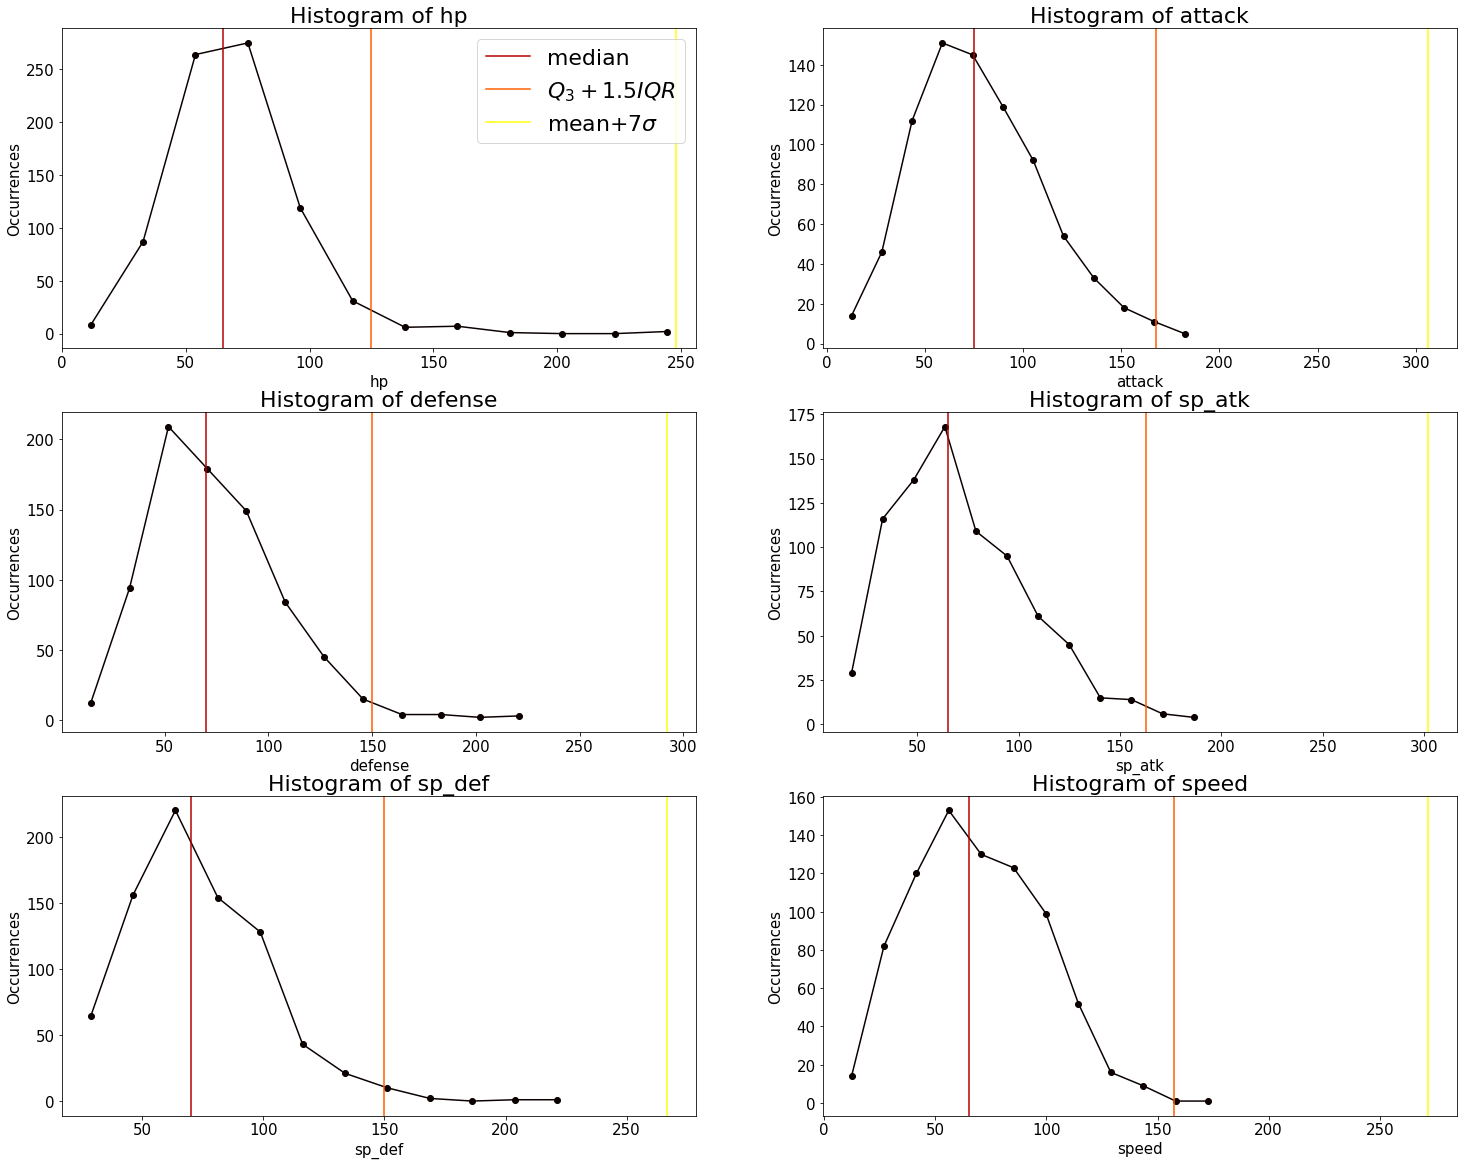

In [18]:
numeric_features = ['hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed']
plotter = CurveClass(nb_curves=4, nrows=3, ncols=2, figsize=(25, 20))
for k, feature_name in enumerate(numeric_features):
    i, j = plotter.ijs[k]
    
    plotter.hist(df_pokemon[feature_name], bins=12, i=i, j=j, marker='o', xlabel=feature_name, ylabel='Occurrences')
    
    median = df_pokemon[feature_name].median()
    q1 = df_pokemon[feature_name].quantile(0.25)
    q3 = df_pokemon[feature_name].quantile(0.75)
    mean = df_pokemon[feature_name].mean()
    std = df_pokemon[feature_name].std()

    plotter.plot_vertical_line(median, label='median', i=i, j=j)
    plotter.plot_vertical_line(q3+1.5*(q3-q1), label='$Q_3+1.5 IQR$', i=i, j=j)
    plotter.plot_vertical_line(mean+7*std, label='mean+7$\sigma$', i=i, j=j)
    
    plotter.title('Histogram of '+feature_name, i, j)
    
plotter.legend(0, 0)


## Merge data

To each battle, we merge the features of the two pokemons.

In [19]:
df_merge = df_battles.copy()

df_temp = df_pokemon.copy()
df_temp = df_temp.rename(columns={c: c+'_p1' for c in df_temp.columns})
df_merge = df_merge.merge(df_temp, how='left', left_on='First_pokemon', right_index=True)

df_temp = df_pokemon.copy()
df_temp = df_temp.rename(columns={c: c+'_p2' for c in df_temp.columns})
df_merge = df_merge.merge(df_temp, how='left', left_on='Second_pokemon', right_index=True)

df_merge['Winner'] = (df_merge['First_pokemon']  == df_merge['Winner']).astype(int)

df_merge

,First_pokemon,Second_pokemon,Winner,name_p1,type1_p1,type2_p1,hp_p1,attack_p1,defense_p1,sp_atk_p1,...,type1_p2,type2_p2,hp_p2,attack_p2,defense_p2,sp_atk_p2,sp_def_p2,speed_p2,generation_p2,legendary_p2
0,4,286,1,Mega Venusaur,17,2,80,100,123,122,...,4,16,70,90,70,60,60,70,3,0
1,559,599,1,Pignite,13,7,90,93,55,70,...,7,16,120,100,85,30,85,45,5,0
2,198,499,0,Bellossom,17,16,75,80,95,90,...,7,8,70,145,88,140,70,112,4,0
3,52,80,0,Paras,5,17,35,70,55,45,...,18,2,80,70,65,80,120,100,1,0
4,209,461,1,Yanma,5,12,65,65,45,75,...,5,8,60,69,95,69,95,36,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9853,126,707,0,Horsea,18,16,30,40,70,70,...,1,13,100,120,100,150,120,90,5,1
9854,589,664,1,Drilbur,9,16,60,85,40,30,...,0,16,35,55,40,45,40,60,5,0
9855,303,368,0,Pelipper,18,12,60,50,100,85,...,3,16,73,115,60,60,60,90,3,0
9856,89,109,0,Magnemite,0,8,25,35,70,95,...,0,16,40,30,50,55,55,100,1,0


# First analyzes and visualisations

## Train data coverage

This part aims to explore the train data coverage, i.e. if the recorded battles give information to enough pokemons to train correctly our models.

It seems than yes. Only 2% of the pokemons do not have a battle recorded. On average, there are 25 battles per pokemons and 90% of them has between 18 and 33 battles recorded.

In a further study, I should check the repartition of battles per pokemon category: per type, per legendary attribut, per generation, per bins of numeric features (attack, defense...). This would be a more systematic validation of the train data coverage.

### There are 16 pokemons with no battle recorded

which represent only 2% of the pokemons.

In [20]:
df_is_in_first_pokemon = df_pokemon.index.isin(df_battles.First_pokemon)
df_is_in_second_pokemon = df_pokemon.index.isin(df_battles.Second_pokemon)
(len(df_pokemon[~(df_is_in_first_pokemon | df_is_in_second_pokemon)])/len(df_pokemon))*100

2.0

### Histogram of the number of battles per pokemons

The following graph shows the histogram of the number of recorded battles per pokemon. In average, there are 25 battles per pokemons, but some pokemons can have from 0 to 40 recorded battles.

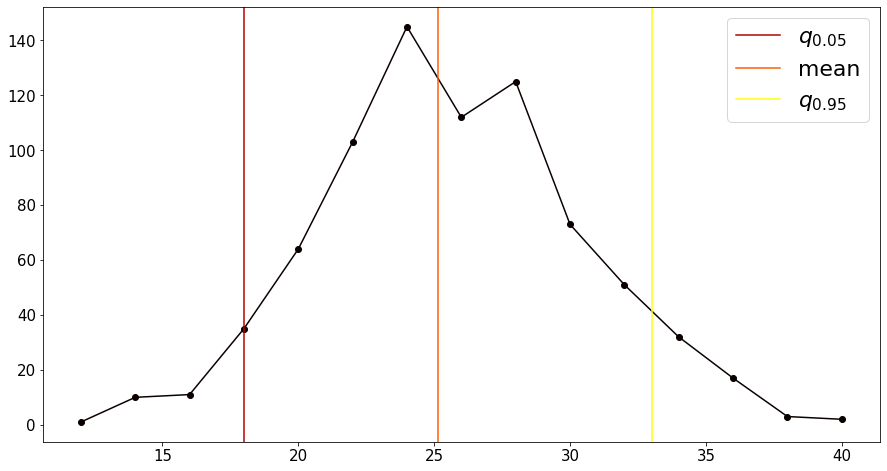

In [21]:
df_temp = pd.concat([df_battles.First_pokemon, df_battles.Second_pokemon]).value_counts()
curve = CurveClass(4)
curve.hist(df_temp, marker='o', bins=15)
curve.plot_vertical_line(df_temp.quantile(0.05), label='$q_{0.05}$')
curve.plot_vertical_line(df_temp.mean(), label='mean')
curve.plot_vertical_line(df_temp.quantile(0.95), label='$q_{0.95}$')
curve.legend()


## Correlations between the features

In this part, I explore the correlation between the absolute features even if in the following I use transformations of them to train my models. This analyze helps to understand the data.

We can observe that there is a correlation block, i.e. attack, special attack, special defense, legendary, hp, speed and defense are correlated between 0.25 and 0.5. That indicates that pokemons are not balanced, i.e. there are weak and strong pokemons. For instance, there are no anti-correlation between defense and attack skills, so globally they are no defensive and offensive pokemons.

On the contrary, strong and weak pokemons are well distributed relatively to types and generation. Thus choosing a particular generation or type pair do not give an advantage in pokemon battle.

That would suggest that I should not use these three features to train my models. I disagree since what is important in a battle is the comparaison of the pokemon skills and not the absolute strength of each of them. It is why in the following I propose to use "relative" features.

### Features correlation matrix

The following figures show the correlation matrix of the features. I ordered the features by the sum of their correlations.

,sp_atk,sp_def,attack,legendary,hp,defense,speed,generation,type1,type2
sp_atk,1.000000,0.506121,0.396362,0.448907,0.362380,0.223549,0.473018,0.036437,0.065934,-0.155959
sp_def,0.506121,1.000000,0.263990,0.363937,0.378718,0.510747,0.259133,0.028486,0.011648,-0.108000
attack,0.396362,0.263990,1.000000,0.345408,0.422386,0.438687,0.381240,0.051451,-0.052506,-0.151698
legendary,0.448907,0.363937,0.345408,1.000000,0.273620,0.246377,0.326715,0.079794,-0.069442,-0.046544
hp,0.362380,0.378718,0.422386,0.273620,1.000000,0.239622,0.175952,0.058683,0.006337,-0.082466
defense,0.223549,0.510747,0.438687,0.246377,0.239622,1.000000,0.015227,0.042419,0.061050,-0.112667
speed,0.473018,0.259133,0.381240,0.326715,0.175952,0.015227,1.000000,-0.023121,-0.145874,-0.098306
generation,0.036437,0.028486,0.051451,0.079794,0.058683,0.042419,-0.023121,1.000000,-0.015853,0.022367
type1,0.065934,0.011648,-0.052506,-0.069442,0.006337,0.061050,-0.145874,-0.015853,1.000000,-0.090162
type2,-0.155959,-0.108000,-0.151698,-0.046544,-0.082466,-0.112667,-0.098306,0.022367,-0.090162,1.000000


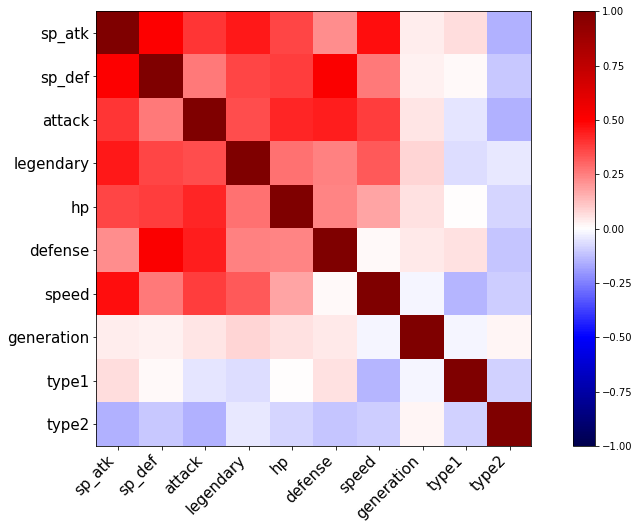

In [22]:
sum_corr = df_pokemon.corr().sum().sort_values(ascending=False).index.values
df_feature_corr = df_pokemon[sum_corr].corr()
display(df_feature_corr)

curve = CurveClass(cmap_name='seismic')
curve.colormap(df_feature_corr, xtick_label=df_feature_corr.columns, ytick_label=df_feature_corr.columns, xlabel_rotation=45, vmin=-1, vmax=1)

# Relative features

For each battle, we have "two dimentionnal" features, i.e. we have two pokemons for each battle and thus two values of each features. What will decide the winner is the relation between the values of the pairs and not the two absolute values.

Moreover battles are symmetric. Giving absolute values to an algorithm might randomly break this symmetry. Indeed unsymmetric features gives unrelevant weight for pokemon 1 or 2 and might mislead the algorithm exploration.

I propose to aggregate each pairs into one value. A question is of course which aggregation function to use : substraction, relative pourcentage, ratio... A further study would be to explore different aggregation functions.

But here I arbitrary choose my aggregation functions. For the numeric features, it will be the substraction divided by the sum: $(f_1-f_2)/(f_1+f_2)$, where $f_1$ and $f_2$ are the values of a given feature of First_pokemon and Second_pokemon. For the categorical features, I will assign a number $f$ for each pair  $(f_1, f_2)$ and the number of  $(f_2, f_1)$ will be $-f$. Morevoer for double pairs $(f_1, f_1)$ the number will be 0. I normalize the features such that the values lie between -1 and 1.

The chosen transformation of the categorical feature is maybe the most questionnable. Indeed, by setting all double pairs to 0, I implement the idea that if the pokemons belong to the same category, the category will play no role into the battle outcome. This might be not true. For instance, during battle between legendary pokemons, the special attack may be more important that for a battle between two normal fighters. Another objection could be that maybe the more relevant is to take into consideration the pair (type 1, type 2) and not this two features separately. For instance, the attack of a Water-Ice pokemon might have a bigger advantage on a Fire-Dragon pokemon. This could be a path to improvement.

Since battles are symetric, I can double the train data by adding the "mirror" data. For each battle, I add its symmetric by multiplying all features by -1 and switching the outcome from win to loose or loose to win.

## Feature build

In [23]:
df_data = df_merge.copy()

        ##### numeric features #####
numeric_feature_names = ['hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed']

for feature_name in numeric_feature_names:
    df_data[feature_name] = (df_data[feature_name+'_p1'] - df_data[feature_name+'_p2'])/(df_data[feature_name+'_p1'] + df_data[feature_name+'_p2'])
    
    
        ##### categorical features #####

    ### assign numeric value to pairs
categorical_feature_names = ['type1', 'type2', 'generation', 'legendary']
    
    ### add new categorical features   

# Types
df_pair_category = h.get_feature_values_for_categorical_pairs(type_numeric_list)
df_data = df_data.merge(df_pair_category, how='left', left_on=['type1_p1', 'type1_p2'], right_on=['feature1', 'feature2'])
df_data = df_data.drop(columns=['feature1', 'feature2'])
df_data = df_data.rename(columns={'feature_pairs': 'type1'})
df_data = df_data.merge(df_pair_category, how='left', left_on=['type2_p1', 'type2_p2'], right_on=['feature1', 'feature2'])
df_data = df_data.drop(columns=['feature1', 'feature2'])
df_data = df_data.rename(columns={'feature_pairs': 'type2'})

# Legendary
df_pair_category = h.get_feature_values_for_categorical_pairs([1, 0])
df_data = df_data.merge(df_pair_category, how='left', left_on=['legendary_p1', 'legendary_p2'], right_on=['feature1', 'feature2'])
df_data = df_data.drop(columns=['feature1', 'feature2'])
df_data = df_data.rename(columns={'feature_pairs': 'legendary'})
# Generation
df_pair_category = h.get_feature_values_for_categorical_pairs(list(df_data['generation_p1'].unique()))
df_data = df_data.merge(df_pair_category, how='left', left_on=['generation_p1', 'generation_p2'], right_on=['feature1', 'feature2'])
df_data = df_data.drop(columns=['feature1', 'feature2'])
df_data = df_data.rename(columns={'feature_pairs': 'generation'})


### remove unsymmetrical features
features_names = numeric_feature_names+categorical_feature_names
df_data = df_data[features_names+['Winner']]

df_data_mirror = df_data.copy()
df_data_mirror = -df_data_mirror
df_data_mirror['Winner'] = 1-df_data['Winner']

df_data = pd.concat([df_data, df_data_mirror]).reset_index(drop=True)
df_data

,hp,attack,defense,sp_atk,sp_def,speed,type1,type2,generation,legendary,Winner
0,0.066667,0.052632,0.274611,0.340659,0.333333,0.066667,-0.461988,0.286550,0.200000,0.0,1
1,-0.142857,-0.036269,-0.214286,0.400000,-0.214286,0.100000,-0.649123,0.666667,0.000000,0.0,1
2,0.034483,-0.288889,0.038251,-0.217391,0.176471,-0.382716,-0.672515,-0.725146,0.733333,0.0,0
3,-0.391304,0.000000,-0.083333,-0.280000,-0.371429,-0.600000,0.543860,-0.292398,0.000000,0.0,0
4,0.040000,-0.029851,-0.357143,0.041667,-0.357143,0.450382,0.000000,-0.701754,0.733333,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
19707,0.538462,0.500000,0.176471,0.363636,0.655172,0.200000,0.204678,0.929825,-0.066667,1.0,1
19708,-0.263158,-0.214286,-0.000000,0.200000,-0.058824,-0.062500,0.052632,-0.000000,-0.000000,-0.0,0
19709,0.097744,0.393939,-0.250000,-0.172414,-0.076923,0.161290,0.385965,-0.900585,-0.000000,-0.0,1
19710,0.230769,-0.076923,-0.166667,-0.266667,-0.000000,0.379310,-0.000000,-0.725146,-0.000000,-0.0,1


## Correlation between relative features and battle outcome

Like with the absolute features, the type and generation features are not correlated between each other and with the other features. Moreover, they are not correlated to the battle outcome, which suggests that these features are not relevant. However this uncorrelation could come from the fact that they are categorical features for which I have chosen arbitrary numbers.

There is again a correlation "block" between the features: defense, HP, special defense, special attack, attack, speed and legendary. Morevover, they are positively correlated to the battle outcome. It is not surprising to have an advantage having one of these features above the opponent ones or being legendary while the opposent is not.

With such correlation, that may be relevant to apply a PCA and thus use fewer but orthogonal features. Thus a further study would to apply a PCA to see if it improves results.

Note that the highest correlation with the battle outcome is from far the speed.

### Correlation matrix

The following figures give the correlation matrix of the relative features and the battle outcomes. The features are ordered in the ascending order of their correlation with the battle outcomes.

,generation,type1,type2,defense,legendary,hp,sp_def,sp_atk,attack,speed,Winner
generation,1.000000,-0.009568,0.020415,-0.068028,-0.064364,-0.013561,-0.065659,-0.050788,-0.024859,-0.018302,-0.018547
type1,-0.009568,1.000000,0.003290,-0.031202,0.043983,-0.016498,-0.009874,-0.096264,0.032134,0.046160,0.046576
type2,0.020415,0.003290,1.000000,0.152306,0.053718,0.105475,0.100364,0.112579,0.139639,0.102870,0.099806
defense,-0.068028,-0.031202,0.152306,1.000000,0.241082,0.347174,0.533615,0.295744,0.528009,0.062006,0.137400
legendary,-0.064364,0.043983,0.053718,0.241082,1.000000,0.272540,0.320551,0.374389,0.279597,0.271866,0.225194
hp,-0.013561,-0.016498,0.105475,0.347174,0.272540,1.000000,0.455485,0.457528,0.493335,0.250439,0.247122
sp_def,-0.065659,-0.009874,0.100364,0.533615,0.320551,0.455485,1.000000,0.559458,0.296544,0.306815,0.263152
sp_atk,-0.050788,-0.096264,0.112579,0.295744,0.374389,0.457528,0.559458,1.000000,0.422154,0.469522,0.365664
attack,-0.024859,0.032134,0.139639,0.528009,0.279597,0.493335,0.296544,0.422154,1.000000,0.374602,0.382172
speed,-0.018302,0.046160,0.102870,0.062006,0.271866,0.250439,0.306815,0.469522,0.374602,1.000000,0.674262


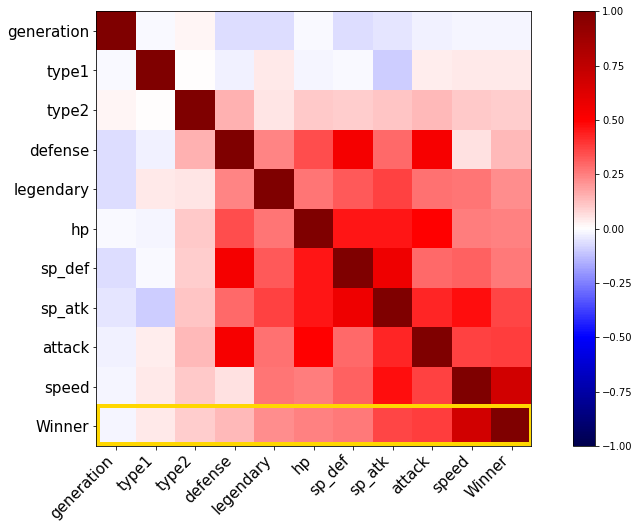

In [24]:
df_corr = df_data.corr()
index = list(df_corr.columns[np.argsort(df_corr['Winner']).values])
df_corr = df_corr.loc[index, index]
display(df_corr)

curve = CurveClass(cmap_name='seismic')
curve.colormap(df_corr, vmin=-1, vmax=1, xtick_label=df_corr.columns, ytick_label=df_corr.columns, xlabel_rotation=45)
rect = pb.Rectangle((-0.45, 9.5), 10.95, 0.95, fill=False, lw=4, color='gold')
curve.ax.add_patch(rect)

## Battle outcome probability vs feature values

If we plot the win probability as a function of feature values, we can observe that the win probability is a linear function of numeric features except the speed. This suggests to use linear models.
The speed feature shows a dichotomic relation between speed and win probability. If speed feature is positive the probability to win is high and vice versa. This suggests that speed is an important feature to take into account.

### plot

The following graphs on the left panel represents the estimated win probability as a function of feature values. On the right panel, we have the 95% binomial confidence interval of the probability estimation as a function of feature values.

For the numeric features, we can see that in the range of feature values for which confidence intervals are not too big (between -0.6 and 0.6), probability to win is a linear function of the feactures (except for the speed).

On the contrary, for categorical features (except for legendary), the win probability do not depend on the feature values (horizontal line along 0.5).

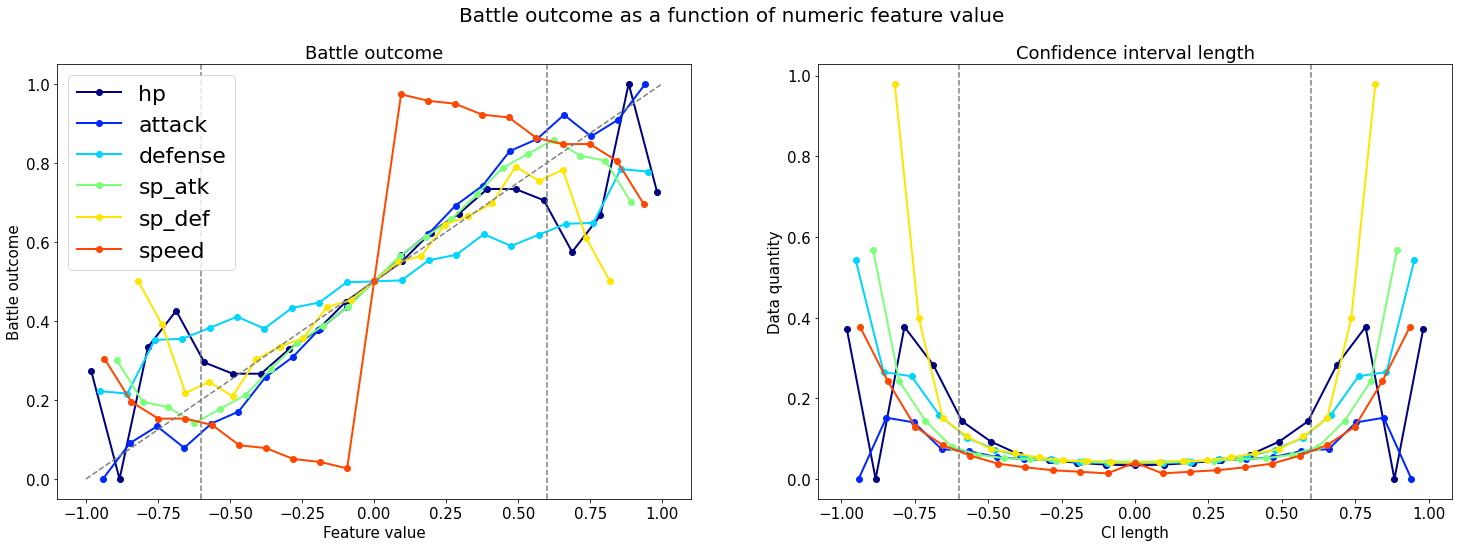

In [25]:
curve = CurveClass(len(numeric_feature_names), ncols=2, cmap_name='jet', figsize=(25, 8), title_size=18)
for feature_name in numeric_feature_names:
    df_mean, df_count = h.mean_columns_per_bins_of_another_columns(df_data, feature_name, 'Winner', bins=20)
    curve.plot(df_mean.index, df_mean, i=0, label=feature_name, lw=2, marker='o', xlabel='Feature value', ylabel='Battle outcome')
    df_temp = 2*1.96*np.sqrt(df_mean*(1-df_mean)/df_count)
    curve.plot(df_count.index, df_temp, i=1, label=feature_name, lw=2, marker='o', xlabel='CI length', ylabel='Data quantity')

curve.fig.suptitle('Battle outcome as a function of numeric feature value', fontsize=20)
curve.title('Battle outcome', i=0)
curve.title('Confidence interval length', i=1)
curve.plot([-1, 1], [0, 1], ls='--', c='grey', i=0)
curve.plot_vertical_line(-.6, ls='--', c='grey', i=0)
curve.plot_vertical_line(-.6, ls='--', c='grey', i=1)
curve.plot_vertical_line(0.6, ls='--', c='grey', i=0)
curve.plot_vertical_line(0.6, ls='--', c='grey', i=1)
curve.legend(i=0)

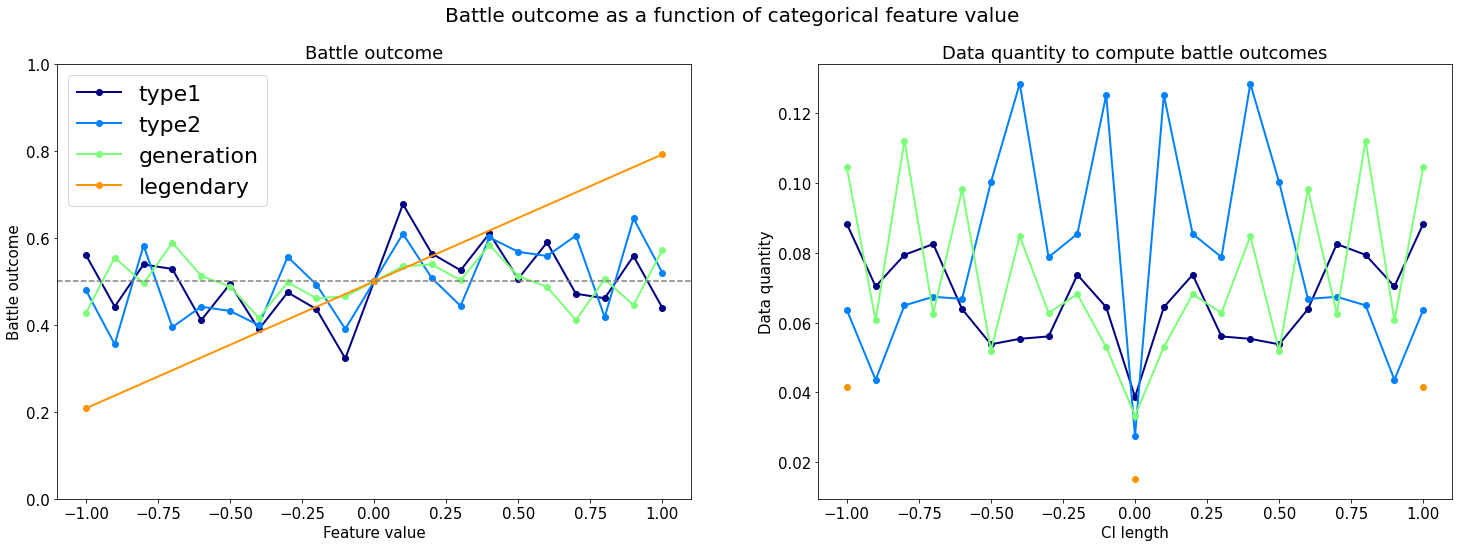

In [26]:
curve = CurveClass(len(categorical_feature_names), ncols=2, cmap_name='jet', figsize=(25, 8), title_size=18)
for feature_name in categorical_feature_names:
    df_mean, df_count = h.mean_columns_per_bins_of_another_columns(df_data, feature_name, 'Winner', bins=20)
    curve.plot(df_mean.index, df_mean, i=0, label=feature_name, lw=2, marker='o', xlabel='Feature value', ylabel='Battle outcome')
    df_temp = 2*1.96*np.sqrt(df_mean*(1-df_mean)/df_count)
    curve.plot(df_count.index, df_temp, i=1, label=feature_name, lw=2, marker='o', xlabel='CI length', ylabel='Data quantity')

curve.fig.suptitle('Battle outcome as a function of categorical feature value', fontsize=20)
curve.title('Battle outcome', i=0)
curve.title('Data quantity to compute battle outcomes', i=1)
curve.plot_horizontal_line(0.5, ls='--', c='grey', i=0)
curve.ax[0].set_ylim(0, 1)
curve.legend(i=0)

# Models

To valuate the models I use the classic metric **accuracy** on the test dataset. Once the "best" model selected, I will validate the result by displaying its accuracy on a validation dataset.

I first test a simple model based of the speed sign. This model gives already a good result : 0.93 of accuracy.

Then I try two machine learning models to try to outperform the speed model.

To reduice time computation and avoid over-fitting, I train them on a limited number of feature combinaisons:
* **all features**;
* all features from the correlation "block": **hp, attach, special attack, defense, special defense, legendary** and **speed**;
* **speed**;
* any combinaison of **speed** and **another feature**.

If the result are not satisfactory, it might be necessary to do more careful feature transformations (categorical to numeric, feature pair aggregation...) and feature combinaison selections.

I used a logistic regression. Indeed the linear relation between the win probability and the numeric features suggests that linear models can work. Unfortunately, this model do not gives better results than the speed model: 0.93 of accuracy on train, test and validation dataset. The fact that accuracy on all the three datasets are rouhghly the same shows that linear regression is not relevant. A reason might be that the numeric features are correlated to the speed and thus do not bring much. Moreover categorical features are not well exploited with linear regressions.

I thus tried a random forest classifier. This model seems promising to exploit the categorcial features and to use speed as a categorical feature (speed positive or not). This models gives indeed better results than the speed model : train, test and validation accuracy respectively around 1, 0.94 and 0.99. Note that to reach this result, the random forest model use all features.

In [27]:
all_features = numeric_feature_names+categorical_feature_names
speed_features = ['speed']
corr_block_features = numeric_feature_names+['legendary']
speed_pair_features = [['speed', feature_name] for feature_name in all_features if feature_name != 'speed']
feature_names_list = [all_features, corr_block_features, speed_features]+speed_pair_features

## Speed model

Since the speed sign is highly correlated with the battle outcome, I start by testing the simple model:
* if speed>0, I predict First_pokemon wins
* if speed<0, I predict Second_pokemon wins
* if speed=0, I predict randomly who wins

This simple model gives an **accuracy of 0.93**, which is already quite good.

In [28]:
df_speed_model_data = df_data.copy()
df_speed_model_data['predict_winner'] = (df_speed_model_data['speed']>0).astype(int)
random_temp = np.random.randint(0, 2, len(df_speed_model_data[df_speed_model_data['speed'] == 0]))
df_speed_model_data.loc[df_speed_model_data['speed'] == 0, 'predict_winner'] = random_temp
print('Simple speed model accuracy :', metrics.accuracy_score(df_speed_model_data['Winner'], df_speed_model_data['predict_winner']))

Simple speed model accuracy : 0.9295353084415584


## Machine learning models

The class HyperparameterExplorationClass test all given hyperparameters of a model.

### Work and validation datasets

In [29]:
df_temp = df_data.copy()

shuffle_index = list(df_temp.index)
np.random.shuffle(shuffle_index)
df_temp = df_temp.loc[shuffle_index].reset_index(drop=True)

validation_size = int(len(df_temp) * 0.1)
df_validation = df_temp.loc[:validation_size, :].copy()
df_work = df_temp.loc[validation_size:, :].copy()

### Logistic regression

Since we are dealing with symmetric data, I set the intercept to 0.

The model regression does not gives a better accuracy than the speed model. It has similar result using the features:
* speed
* speed and type 1
* speed and generation

In [30]:
logistic_regression_hyper_para_exploration = Models.HyperparameterExplorationClass(
    model_class=Models.LogisticRegressionClass,
    feature_names_list=feature_names_list,
    para_tuple_list=[],
    para_names=[],
    df_data=df_data, 
    df_validation=df_validation)
logistic_regression_hyper_para_exploration.exploration()
logistic_regression_hyper_para_exploration.print_all_models_equal_or_better_than_speed_model()

#### All models ####
##
LogisticRegression
features:  ['speed', 'legendary']

## Train accuracy: 0.923
## Test accuracy: 0.93



### Random Forest

Random forest model gives better results:
* train accuracy = 1
* test accuracy = 0.94

In [31]:
n_estimators_list = [10, 50, 100]
max_depth_list = list(range(1, 4))
para_tuple_list = [(n, m) for n in n_estimators_list for m in max_depth_list]
para_tuple_list += [(n, None) for n in n_estimators_list]

In [32]:
random_forest_hyper_para_exploration = Models.HyperparameterExplorationClass(
    model_class=Models.RandomForestClass,
    feature_names_list=feature_names_list,
    para_tuple_list=para_tuple_list,
    para_names=['n_estimators', 'max_depth'],
    df_data=df_data, 
    df_validation=df_validation)
random_forest_hyper_para_exploration.exploration()

random_forest_hyper_para_exploration.print_best_model()

#### Best model ####
RandomForest
features:  ['hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed', 'type1', 'type2', 'generation', 'legendary']
parameters:  {'n_estimators': 100, 'max_depth': None}

## Train accuracy: 1.0
## Test accuracy: 0.942



## Validation

Validation confirms that:
* Logistic regression gives a validation accuracy around 0.93 (with features 'speed'), which is equivalent to the speed model performance
* Random Forest is better than the speed model with a validation accuracy around 0.99

In [33]:
logistic_regression_hyper_para_exploration.print_best_model_validation()

#### Best model validation####
## LogisticRegression
Validation accuracy: 0.921


,Negative,Positive
False,0.9363,0.0637
True,0.0936,0.9064


In [34]:
random_forest_hyper_para_exploration.print_best_model_validation()

#### Best model validation####
## RandomForest
Validation accuracy: 0.987


,Negative,Positive
False,0.9848,0.0152
True,0.0102,0.9898
